In [1]:
import numpy as np
import pandas as pd

In [2]:
from __future__ import print_function
import matplotlib.pyplot as plt
%matplotlib inline
from plot_functions import *
from sklearn.model_selection import KFold

In [3]:
from create_matrix import *
import os
from tensor_custom_core import *
from create_matrix import *
from tensor_custom_core import *
from degree_days import dds
import sys


appliance_index = {appliance: APPLIANCES_ORDER.index(appliance) for appliance in APPLIANCES_ORDER}
APPLIANCES = ['fridge', 'hvac', 'wm', 'mw', 'oven', 'dw']
region = "SanDiego"
year = 2014




def un_normalize(x, maximum, minimum):
    return (maximum - minimum) * x + minimum

In [4]:
n_splits = 10
case=2
cost='abs'

In [5]:
def get_tensor(df, dfc):
    start, stop = 1, 13
    energy_cols = np.array(
        [['%s_%d' % (appliance, month) for month in range(start, stop)] for appliance in APPLIANCES_ORDER]).flatten()

    static_cols = ['area', 'total_occupants', 'num_rooms']
    static_df = df[static_cols]
    static_df = static_df.div(static_df.max())
    weather_values = np.array(dds[2014][region][start - 1:stop - 1]).reshape(-1, 1)

    dfc = df.copy()

    df = dfc[energy_cols]
    col_max = df.max().max()
    col_min = df.min().min()
    # df = (1.0 * (df - col_min)) / (col_max - col_min)
    tensor = df.values.reshape((len(df), 7, stop - start))
    M, N, O = tensor.shape
    return tensor

In [6]:
sd_df, sd_dfc = create_matrix_single_region("SanDiego", year)
sd_tensor = get_tensor(sd_df, sd_dfc)
au_df, au_dfc = create_matrix_single_region("Austin", year)
au_tensor = get_tensor(au_df, au_dfc)

In [7]:
from sklearn.model_selection import train_test_split, KFold
from common import compute_rmse

In [8]:
iters = 1000
a = 3

In [36]:
H_series = {}
A_series = {}
T_series = {}
HAT_series = {}
cost_series = {}
HAT_au = {}

As_au = {}

H, As_au[2000], T = learn_HAT(case, au_tensor, a, a, num_iter=2000, lr=0.1, dis=False, cost_function=cost, T_known=np.ones(12).reshape(-1, 1))
H, As_au[4000], T = learn_HAT(case, au_tensor, a, a, num_iter=4000, lr=0.1, dis=False, cost_function=cost, T_known=np.ones(12).reshape(-1, 1))
H, As_au[6000], T = learn_HAT(case, au_tensor, a, a, num_iter=6000, lr=0.1, dis=False, cost_function=cost, T_known=np.ones(12).reshape(-1, 1))
H, As_au[8000], T = learn_HAT(case, au_tensor, a, a, num_iter=8000, lr=0.1, dis=False, cost_function=cost, T_known=np.ones(12).reshape(-1, 1))
H, As_au[10000], T = learn_HAT(case, au_tensor, a, a, num_iter=10000, lr=0.1, dis=False, cost_function=cost, T_known=np.ones(12).reshape(-1, 1))


In [37]:
for iters in [2000, 4000, 6000, 8000, 10000]:

    H, A, T, Hs, As, Ts, HATs, costs = learn_HAT_random_normal(case, sd_tensor, a, a, num_iter=10000, lr=0.1, dis=False, cost_function=cost,A_known = As_au[iters], T_known=np.ones(12).reshape(-1, 1))
    
    H_series[iters] = Hs
    A_series[iters] = As
    T_series[iters] = Ts
    HAT_series[iters] = HATs
    cost_series[iters] = costs

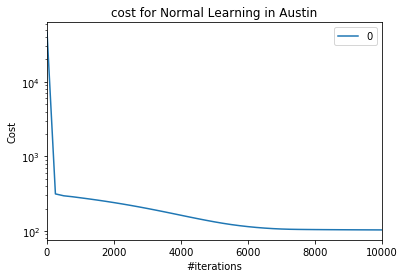

In [10]:
step=250
idx = np.arange(0, 10100, 250)

tdf = pd.DataFrame(costs_au[::step], index=idx)
tdf.plot(logy=True)
plt.title("cost for Normal Learning in Austin")
plt.ylabel("Cost")
plt.xlabel("#iterations")

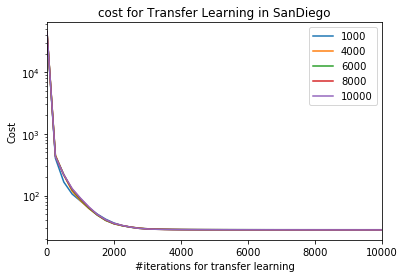

In [38]:
step=250
idx = np.arange(0, 10100, 250)
dfs = pd.DataFrame(cost_series[2000][::step], index=idx, columns={str(1000)})
for iters in [4000, 6000, 8000, 10000]:
    tdf = pd.DataFrame(cost_series[iters][::step], index=idx, columns={str(iters)})
    dfs = pd.concat([dfs, tdf], axis = 1)
dfs.plot(logy=True)
plt.title("cost for Transfer Learning in SanDiego")
plt.ylabel("Cost")
plt.xlabel("#iterations for transfer learning")

In [58]:
pred = {}   
        
for iters in [2000, 4000, 6000, 8000, 10000]:
    pred[iters] = {}
    for appliance in APPLIANCES_ORDER:
        pred[iters][appliance] = {f:[] for f in range(250, 10010, 250)}
        
for iters in [2000, 4000, 6000, 8000, 10000]:
    for iter_transfer in range(250, 10010, 250):
        for appliance_name, appliance_id in appliance_index.iteritems():
            pred[iters][appliance_name][iter_transfer].append(pd.DataFrame(HAT_series[iters][iter_transfer][:, appliance_id, :], index=sd_df.index))

In [59]:
from common import compute_rmse_fraction

out = {}

for iters in [2000, 4000, 6000, 8000, 10000]:
    out[iters] = {}    
    for appliance in APPLIANCES_ORDER[1:]:
        out[iters][appliance] = {}
        for f in range(250,10010, 250):
            s = pd.concat(pred[iters][appliance][f]).ix[sd_df.index]
            if appliance=="hvac":
                out[iters][appliance][f] = compute_rmse_fraction(appliance,s[range(4, 10)],'SanDiego')[2]
            else:   
                out[iters][appliance][f] = compute_rmse_fraction(appliance, s,'SanDiego')[2]

/home/yj9xs/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:10: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix


In [62]:
pd_out = {}
for iters in [2000, 4000, 6000, 8000, 10000]:
    pd_out[iters] = pd.DataFrame(out[iters])
    pd_out[iters] = pd_out[iters].rename( columns = 
                                         {'dw': "dw_" + str(iters),
                                          'wm': "wm_" + str(iters),
                                          'mw': "mw_" + str(iters),
                                          'oven': "oven_" + str(iters),
                                          'fridge': "fridge_"+ str(iters),
                                          'hvac': "hvac_" + str(iters)})

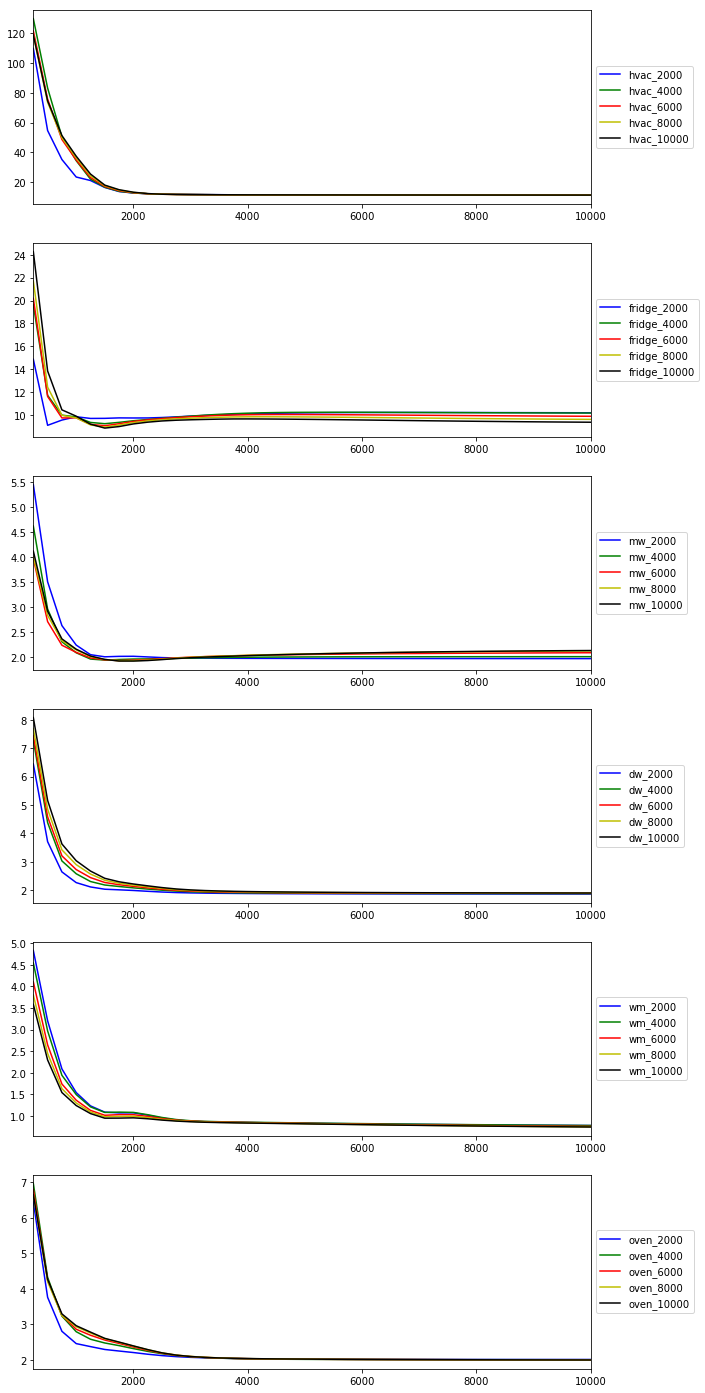

In [63]:
fig, axes = plt.subplots(nrows=6, ncols=1, figsize=(10, 15))
ax = axes.flatten()
count = 0


# df['A'].plot(ax=axes[0,0]); axes[0,0].set_title('A')
for appliance in APPLIANCES_ORDER[1:]:
    dfs = {}
    num = 0
    for iters in [2000, 4000, 6000, 8000, 10000]:
        dfs[num] = pd_out[iters][appliance + "_" + str(iters)]
        num += 1
    df = pd.concat([dfs[0], dfs[1]], axis = 1)
    for i in range(2, 5):
        df = pd.concat([df, dfs[i]], axis = 1)

    pd.DataFrame(df).plot(ax=ax[count],figsize=(10, 25),xlim=(250, 10010), color=['b', 'g','r', 'y', 'k', 'c'])
    ax[count].legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
#     ax[count].set_xlabel("iterations")
    count += 1
    
plt.savefig("./analysis/0720/training_error.pdf", bbox_inches="tight", dpi=300, format="pdf")

### For Test error

In [17]:
case = 2
a = 3
iter_adapt = 4000

pred = {}
for iter_train in [2000, 4000, 6000, 8000, 10000]:
    pred[iter_train] = {}
    for random_seed in range(10):
        pred[iter_train][random_seed] = {}
        for appliance in APPLIANCES_ORDER:
            pred[iter_train][random_seed][appliance] = {f:[] for f in range(10, 110, 10)}

kf = KFold(n_splits=n_splits)
for iter_train in [2000, 4000, 6000, 8000, 10000]:
    print ("iter_train:", iter_train)
    for random_seed in range(10):
        print ("random_seed:", random_seed)
        for train_percentage in range(10, 110, 10):
            print ("train_percentage:", train_percentage)
            rd = 0
            for train_max, test in kf.split(sd_df):
                print ("rd:", rd)
                rd += 1

                num_train = int((train_percentage*len(train_max)/100)+0.5)
                if train_percentage==100:
                    train = train_max
                else:
                    train, _ = train_test_split(train_max, train_size = train_percentage/100.0, random_state=random_seed)
                train_ix = sd_df.index[train]
                test_ix = sd_df.index[test]

                num_test = len(test_ix)
                train_test_ix = np.concatenate([test_ix, train_ix])
                df_t, dfc_t = sd_df.ix[train_test_ix], sd_dfc.ix[train_test_ix]
                tensor = get_tensor(df_t, dfc_t)
                tensor_copy = tensor.copy()
                # First n
                tensor_copy[:num_test, 1:, :] = np.NaN

                H, A, T = learn_HAT(case, tensor_copy, a, a, num_iter=iter_adapt, lr=0.1, dis=False, cost_function=cost, A_known=As_au[iter_train], T_known=np.ones(12).reshape(-1, 1))

                HAT = multiply_case(H, A, T, case)
                for appliance in APPLIANCES_ORDER:
                    pred[iter_train][random_seed][appliance][train_percentage].append(pd.DataFrame(HAT[:num_test, appliance_index[appliance], :], index=test_ix))

iter_train: 2000
random_seed: 0
train_percentage: 10
rd: 0


/home/yj9xs/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:35: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix


rd: 1
rd: 2
rd: 3
rd: 4
rd: 5
rd: 6
rd: 7
rd: 8
rd: 9
train_percentage: 20
rd: 0
rd: 1
rd: 2
rd: 3
rd: 4
rd: 5
rd: 6
rd: 7
rd: 8
rd: 9
train_percentage: 30
rd: 0
rd: 1
rd: 2
rd: 3
rd: 4
rd: 5
rd: 6
rd: 7
rd: 8
rd: 9
train_percentage: 40
rd: 0
rd: 1
rd: 2
rd: 3
rd: 4
rd: 5
rd: 6
rd: 7
rd: 8
rd: 9
train_percentage: 50
rd: 0
rd: 1
rd: 2
rd: 3
rd: 4
rd: 5
rd: 6
rd: 7
rd: 8
rd: 9
train_percentage: 60
rd: 0
rd: 1
rd: 2
rd: 3
rd: 4
rd: 5
rd: 6
rd: 7
rd: 8
rd: 9
train_percentage: 70
rd: 0
rd: 1
rd: 2
rd: 3
rd: 4
rd: 5
rd: 6
rd: 7
rd: 8
rd: 9
train_percentage: 80
rd: 0
rd: 1
rd: 2
rd: 3
rd: 4
rd: 5
rd: 6
rd: 7
rd: 8
rd: 9
train_percentage: 90
rd: 0
rd: 1
rd: 2
rd: 3
rd: 4
rd: 5
rd: 6
rd: 7
rd: 8
rd: 9
train_percentage: 100
rd: 0
rd: 1
rd: 2
rd: 3
rd: 4
rd: 5
rd: 6
rd: 7
rd: 8
rd: 9
random_seed: 1
train_percentage: 10
rd: 0
rd: 1
rd: 2
rd: 3
rd: 4
rd: 5
rd: 6
rd: 7
rd: 8
rd: 9
train_percentage: 20
rd: 0
rd: 1
rd: 2
rd: 3
rd: 4
rd: 5
rd: 6
rd: 7
rd: 8
rd: 9
train_percentage: 30
rd: 0
rd: 1
rd: 2


In [47]:
def load_obj(name):
    with open(os.path.expanduser('~/git/' + name + '.pkl'), 'rb') as f:
        return pickle.load(f)

In [48]:
import pickle
pred = {}
for iterations in [2000, 4000, 6000, 8000, 10000]:
    pred[iterations] = {}
    for random_seed in range(10):
        print (iterations, random_seed)
        pred[iterations][random_seed] = load_obj('overfit/pred_' + str(iterations) + "_" + str(random_seed))

2000 0
2000 1
2000 2
2000 3
2000 4
2000 5
2000 6
2000 7
2000 8
2000 9
4000 0
4000 1
4000 2
4000 3
4000 4
4000 5
4000 6
4000 7
4000 8
4000 9
6000 0
6000 1
6000 2
6000 3
6000 4
6000 5
6000 6
6000 7
6000 8
6000 9
8000 0
8000 1
8000 2
8000 3
8000 4
8000 5
8000 6
8000 7
8000 8
8000 9
10000 0
10000 1
10000 2
10000 3
10000 4
10000 5
10000 6
10000 7
10000 8
10000 9


In [49]:
out = {}

for iter_train in [2000, 4000, 6000, 8000, 10000]:
    out[iter_train] = {}
    for random_seed in range(10):
        out[iter_train][random_seed] = {}
        for appliance in APPLIANCES_ORDER[1:]:
            out[iter_train][random_seed][appliance] = {}
            for f in range(10,110,10):
                s = pd.concat(pred[iter_train][random_seed][appliance][f]).ix[sd_df.index]
                if appliance=="hvac":
                    out[iter_train][random_seed][appliance][f] = compute_rmse_fraction(appliance,s[range(4, 10)],'SanDiego')[2]
                else:   
                    out[iter_train][random_seed][appliance][f] = compute_rmse_fraction(appliance, s,'SanDiego')[2]

/home/yj9xs/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:10: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix


In [50]:
mean_out = {}
for iters in [2000, 4000, 6000, 8000, 10000]:
    mean_out[iters] = pd.Panel(out[iters]).mean(axis=0)

In [51]:
pd_out = {}
for iters in [2000, 4000, 6000, 8000, 10000]:
    pd_out[iters] = pd.DataFrame(mean_out[iters])
    pd_out[iters] = pd_out[iters].rename( columns = 
                                         {'dw': "dw_" + str(iters),
                                          'wm': "wm_" + str(iters),
                                          'mw': "mw_" + str(iters),
                                          'oven': "oven_" + str(iters),
                                          'fridge': "fridge_"+ str(iters),
                                          'hvac': "hvac_" + str(iters)})

In [52]:
pd_out[2000]

,dw_2000,fridge_2000,hvac_2000,mw_2000,oven_2000,wm_2000
10,1.930441,8.861838,47.245441,2.044628,2.259337,0.720369
20,1.863918,9.315891,29.452562,1.991197,2.077893,0.754415
30,1.821381,9.844054,22.593538,1.999756,2.101233,0.770951
40,1.798085,10.350761,18.658125,2.035505,2.126578,0.787774
50,1.795321,10.359477,17.660407,2.035878,2.109966,0.786380
60,1.795947,10.342511,17.160788,2.044517,2.115849,0.785912
70,1.795011,10.308195,16.743277,2.049552,2.111935,0.783669
80,1.798679,10.283192,16.188279,2.059046,2.101944,0.787472
90,1.800452,10.241133,15.829586,2.063509,2.099117,0.789669
100,1.801589,10.241842,15.692970,2.071536,2.097492,0.796057


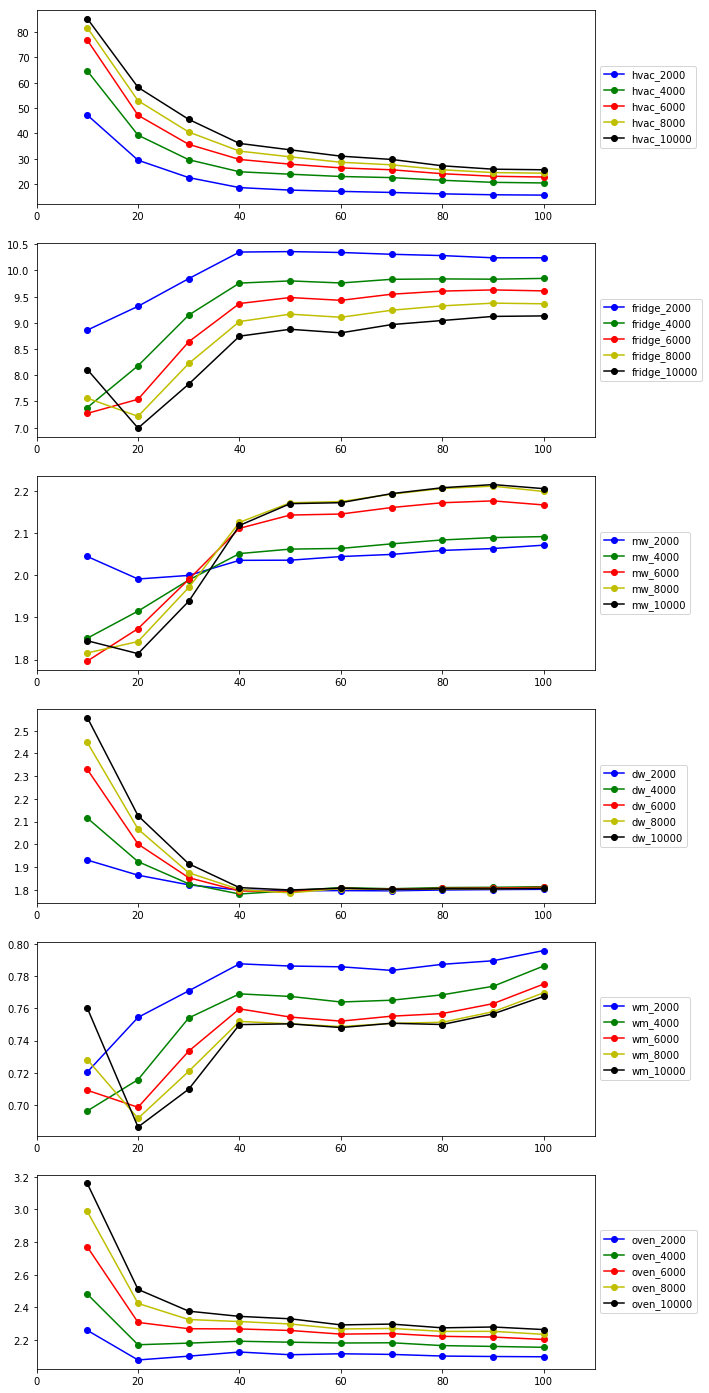

In [61]:
fig, axes = plt.subplots(nrows=6, ncols=1, figsize=(10, 15))
ax = axes.flatten()
count = 0


# df['A'].plot(ax=axes[0,0]); axes[0,0].set_title('A')
for appliance in APPLIANCES_ORDER[1:]:
    dfs = {}
    num = 0
    for iters in [2000, 4000, 6000, 8000, 10000]:
        dfs[num] = pd_out[iters][appliance + "_" + str(iters)]
        num += 1
    df = pd.concat([dfs[0], dfs[1]], axis = 1)
    for i in range(2, 5):
        df = pd.concat([df, dfs[i]], axis = 1)

    pd.DataFrame(df).plot(ax=ax[count],figsize=(10, 25), marker='o', xlim=(0, 110), color=['b', 'g','r', 'y', 'k', 'c'])
    ax[count].legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    count += 1
plt.savefig("./analysis/0720/test_error.pdf", bbox_inches="tight", dpi=300, format="pdf")